In [9]:
 ! pip install -q kaggle

In [10]:
from google.colab import files

In [11]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abderrahmaneabdelje","key":"1eed7aa0bcac823ccbf4681840659440"}'}

In [12]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5733  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3171  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1111  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1870  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [16]:
!kaggle datasets download -d ruizgara/socofing

 98% 821M/838M [00:07<00:00, 114MB/s]
100% 838M/838M [00:07<00:00, 116MB/s]


In [17]:
! mkdir train

In [18]:
! unzip socofing.zip -d train

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/socofing/SOCOFing/Real/191__F_Left_index_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Left_little_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Left_middle_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Left_ring_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Left_thumb_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Right_index_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Right_little_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Right_middle_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Right_ring_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/191__F_Right_thumb_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/192__M_Left_index_finger.BMP  
  inflating: train/socofing/SOCOFing/Real/192__M_Left_little_finger.BMP  
  inflating: train/socofing/SOCOFing/R

In [19]:
!ls

kaggle.json  sample_data  socofing.zip	train


In [20]:
%cd train/

/content/train


In [21]:
!ls

socofing  SOCOFing


In [22]:
%cd socofing/

/content/train/socofing


# Import Library


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2
import matplotlib.pyplot as plt
import random
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt



# Util Functions 

In [24]:
def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')
  
  if train:
      gender, lr, finger, _, _ = etc.split('_')
  else:
      gender, lr, finger, _ = etc.split('_')
  
  gender = 0 if gender == 'M' else 1
  lr = 0 if lr == 'Left' else 1

  if finger == 'thumb':
      finger = 0
  elif finger == 'index':
      finger = 1
  elif finger == 'middle':
      finger = 2
  elif finger == 'ring':
      finger = 3
  elif finger == 'little':
      finger = 4
  return np.array([gender], dtype=np.uint16)

#Image size 
img_size = 96

def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    data
    return data




# Load data

In [25]:
Real_path = "/content/train/socofing/SOCOFing/Real"
Easy_path = "/content/train/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "/content/train/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "/content/train/socofing/SOCOFing/Altered/Altered-Hard"

Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

del Easy_data, Medium_data, Hard_data


loading data from:  /content/train/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  /content/train/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  /content/train/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  /content/train/socofing/SOCOFing/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
random.shuffle(data)
random.shuffle(test)
data

array([[0,
        array([[160, 158, 158, ...,   0,   0,   0],
       [160, 105, 121, ...,   0,   0,   0],
       [160, 105, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
       [0,
        array([[160, 158, 158, ...,   0,   0,   0],
       [160, 105, 121, ...,   0,   0,   0],
       [160, 105, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
       [0,
        array([[160, 158, 158, ...,   0,   0,   0],
       [160, 105, 121, ...,   0,   0,   0],
       [160, 105, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
       ...,
       [0,
        array([[160, 158, 158, ...,   0,   0

In [27]:
img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0

train_labels = to_categorical(labels, num_classes = 2)





del data
train_data



train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
train_data

array([[[[0.62745098],
         [0.61960784],
         [0.61960784],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.62745098],
         [0.41176471],
         [0.4745098 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.62745098],
         [0.41176471],
         [1.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.62745098],
         [0.61960784],
         [0.61

# Define Model

In [29]:
model = Sequential([
                    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(2, activation = 'softmax'),
                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [32]:
model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [33]:
history = model.fit(train_data, train_labels, batch_size = 128, epochs = 30, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/30
308/308 [==============================] - 43s 34ms/step - loss: 1.1646 - accuracy: 0.7643 - val_loss: 0.4524 - val_accuracy: 0.7951
Epoch 2/30
308/308 [==============================] - 9s 30ms/step - loss: 0.4110 - accuracy: 0.8081 - val_loss: 0.3485 - val_accuracy: 0.8433
Epoch 3/30
308/308 [==============================] - 9s 30ms/step - loss: 0.2813 - accuracy: 0.8861 - val_loss: 0.2429 - val_accuracy: 0.9158
Epoch 4/30
308/308 [==============================] - 9s 30ms/step - loss: 0.1750 - accuracy: 0.9510 - val_loss: 0.1865 - val_accuracy: 0.9350
Epoch 5/30
308/308 [==============================] - 9s 30ms/step - loss: 0.1058 - accuracy: 0.9808 - val_loss: 0.1401 - val_accuracy: 0.9603
Epoch 6/30
308/308 [==============================] - 9s 30ms/step - loss: 0.0690 - accuracy: 0.9917 - val_loss: 0.1086 - val_accuracy: 0.9716
Epoch 7/30
308/308 [==============================] - 9s 31ms/step - loss: 0.0463 - accuracy: 0.9957 - val_loss: 0.0926 - val_accuracy: 0.975

# Visualisation

(0.0, 1.0)

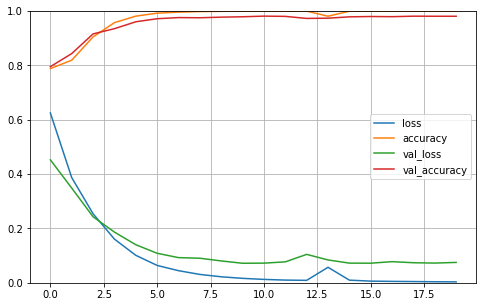

In [36]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [37]:
test

[[0, array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0, array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0, array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0, array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121,

In [38]:
test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)

In [39]:
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0
del test
test_labels  = to_categorical(test_labels, num_classes = 2)
test_images

array([[[[0.62745098],
         [0.61960784],
         [0.61960784],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.62745098],
         [0.41176471],
         [0.4745098 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.62745098],
         [0.41176471],
         [1.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.62745098],
         [0.61960784],
         [0.61

In [40]:
model.evaluate(test_images, test_labels)

188/188 [==============================] - 1s 5ms/step - loss: 0.0200 - accuracy: 0.9970


[0.01997896283864975, 0.996999979019165]